## Generate NUM_PATIENTS_PER_LABEL cases for training (2 labels: No hemorrhage and Most occurrence hemorrhage type)

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Define paths
dataset_path = 'E:/rsna-intracranial-hemorrhage-detection'
destination_dir = 'E:/rsna-mil-training'
train_images_dir = 'E:/rsna-intracranial-hemorrhage-detection/stage_2_train'
scan_level_dataset = 'C:/Users/MINH/Downloads/Coding/HCMUS/Thesis/Brain-Stroke-Diagnosis/rsna/data_analyze/scan_level_dataset.csv'
filename = 'C:/Users/MINH/OneDrive - nhatminhtrieu1/Thesis 2025 Storage/RSNA_Datasheet/sorted_training_dataset_with_labels.csv'

# Create destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

In [5]:
# Read file csv as a dataframe
raw_df = pd.read_csv(filename)

raw_df.head()

,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,patient_id,study_instance_uid,series_instance_uid,image_position,samples_per_pixel,pixel_spacing,pixel_representation,window_center,window_width,rescale_intercept,rescale_slope,ID
0,ID_45785016b.dcm,0,0,0,0,0,0,ID_0002cd41,ID_66929e09d4,ID_e22a5534e6,"[-125.000, -122.596, 35.968]",1,"[0.488281, 0.488281]",1,30,80,-1024.0,1.0,45785016b
1,ID_37f32aed2.dcm,0,0,0,0,0,0,ID_0002cd41,ID_66929e09d4,ID_e22a5534e6,"[-125.000, -122.596, 38.484]",1,"[0.488281, 0.488281]",1,30,80,-1024.0,1.0,37f32aed2
2,ID_1b9de2922.dcm,0,0,0,0,0,0,ID_0002cd41,ID_66929e09d4,ID_e22a5534e6,"[-125.000, -122.596, 41.000]",1,"[0.488281, 0.488281]",1,30,80,-1024.0,1.0,1b9de2922
3,ID_d61a6a7b9.dcm,0,0,0,0,0,0,ID_0002cd41,ID_66929e09d4,ID_e22a5534e6,"[-125.000, -122.596, 43.517]",1,"[0.488281, 0.488281]",1,30,80,-1024.0,1.0,d61a6a7b9
4,ID_406c82112.dcm,0,0,0,0,0,0,ID_0002cd41,ID_66929e09d4,ID_e22a5534e6,"[-125.000, -122.596, 46.033]",1,"[0.488281, 0.488281]",1,30,80,-1024.0,1.0,406c82112


In [6]:
raw_df.columns

Index(['filename', 'any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural', 'patient_id', 'study_instance_uid',
       'series_instance_uid', 'image_position', 'samples_per_pixel',
       'pixel_spacing', 'pixel_representation', 'window_center',
       'window_width', 'rescale_intercept', 'rescale_slope', 'ID'],
      dtype='object')

In [7]:
# Read scan_level_dataset.csv as a DataFrame 
scan_level_df = pd.read_csv(scan_level_dataset)

In [8]:
scan_level_df.columns

Index(['patient_id', 'study_instance_uid', 'any', 'epidural',
       'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural'],
      dtype='object')

In [9]:
## CASE: UNIQUE PATIENTS PER LABEL
# Define the number of unique patients to extract per hemorrhage label
NUM_PATIENTS_PER_LABEL = 500

# Function to extract unique patients based on a specified condition
def extract_unique_patients(df, condition, num_patients, excluded_ids):
    """Extract unique patients based on a specific condition, excluding certain IDs."""
    unique_patients = df[condition & ~df['patient_id'].isin(excluded_ids)].groupby('patient_id').first().reset_index()
    return unique_patients.head(num_patients)

# List of hemorrhage types
hemorrhage_types = ['intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'epidural']

# Initialize a list to store extracted patients
extracted_patients_list = []

# Initialize a set to keep track of already selected patient IDs
selected_patient_ids = set()

# Extract patients with no hemorrhage (0 for all hemorrhage columns)
no_hemorrhage_condition = (scan_level_df[hemorrhage_types] == 0).all(axis=1)
unique_no_hemorrhage_patients = extract_unique_patients(scan_level_df, no_hemorrhage_condition, NUM_PATIENTS_PER_LABEL, selected_patient_ids)
extracted_patients_list.append(unique_no_hemorrhage_patients)
selected_patient_ids.update(unique_no_hemorrhage_patients['patient_id'])

# Determine the most prevalent hemorrhage type by counting positive cases
hemorrhage_counts = scan_level_df[hemorrhage_types].sum()
most_prevalent_hemorrhage_type = hemorrhage_counts.idxmax()

# Extract patients for the most prevalent hemorrhage type
most_prevalent_condition = scan_level_df[most_prevalent_hemorrhage_type] == 1
unique_most_prevalent_patients = extract_unique_patients(scan_level_df, most_prevalent_condition, NUM_PATIENTS_PER_LABEL, selected_patient_ids)
extracted_patients_list.append(unique_most_prevalent_patients)
selected_patient_ids.update(unique_most_prevalent_patients['patient_id'])

# Concatenate all extracted patients
extracted_patients = pd.concat(extracted_patients_list, ignore_index=True)

In [10]:
# ## CASE: UNIQUE PATIENTS PER LABEL
# # Define the number of unique patients to extract per hemorrhage label
# NUM_PATIENTS_PER_LABEL = 2
# 
# # Function to extract unique patients based on a specified condition
# def extract_unique_patients(df, condition, num_patients, excluded_ids):
#     """Extract unique patients based on a specific condition, excluding certain IDs."""
#     unique_patients = df[condition & ~df['patient_id'].isin(excluded_ids)].groupby('patient_id').first().reset_index()
#     return unique_patients.head(num_patients)
# 
# # List of hemorrhage types
# hemorrhage_types = ['intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'epidural']
# 
# # Initialize a list to store extracted patients
# extracted_patients_list = []
# 
# # Initialize a set to keep track of already selected patient IDs
# selected_patient_ids = set()
# 
# # Extract patients for each hemorrhage type
# for hemorrhage_type in hemorrhage_types:
#     condition = scan_level_df[hemorrhage_type] == 1
# 
#     unique_patients = extract_unique_patients(scan_level_df, condition, NUM_PATIENTS_PER_LABEL, selected_patient_ids)
# 
#     extracted_patients_list.append(unique_patients)
#     selected_patient_ids.update(unique_patients['patient_id'])
# 
# # Extract patients with no hemorrhage
# no_hemorrhage_condition = (scan_level_df[hemorrhage_types] == 0).all(axis=1)
# unique_no_hemorrhage_patients = extract_unique_patients(scan_level_df, no_hemorrhage_condition, NUM_PATIENTS_PER_LABEL, selected_patient_ids)
# extracted_patients_list.append(unique_no_hemorrhage_patients)
# 
# # Concatenate all extracted patients
# extracted_patients = pd.concat(extracted_patients_list, ignore_index=True)

In [11]:
extracted_patients.head(100)

,patient_id,study_instance_uid,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_0002cd41,ID_66929e09d4,0,0,0,0,0,0
1,ID_00054f3f,ID_8a449ae31b,0,0,0,0,0,0
2,ID_0006d192,ID_25690b4725,0,0,0,0,0,0
3,ID_00086119,ID_fdde2979b0,0,0,0,0,0,0
4,ID_000e5623,ID_9a4be35b9a,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
95,ID_025083a3,ID_98e9c9ca33,0,0,0,0,0,0
96,ID_02584b75,ID_6220a4bd85,0,0,0,0,0,0
97,ID_0260b549,ID_f7e5f505fc,0,0,0,0,0,0
98,ID_02689616,ID_2edd54174e,0,0,0,0,0,0


In [12]:
# Get patient_id and study_instance_uid
patient_ids = extracted_patients['patient_id']
study_uids = extracted_patients['study_instance_uid']

In [13]:
# Save the extracted patients to a new CSV file
extracted_patients.to_csv('training_1000_scan_subset.csv', index=False)

In [14]:
# Initialize a list to hold filenames
filenames_to_copy = []

# Iterate through the extracted patient IDs and study UIDs
for patient_id, study_uid in zip(patient_ids, study_uids):
    matching_files = raw_df[(raw_df['patient_id'] == patient_id) & 
                            (raw_df['study_instance_uid'] == study_uid)]
    # Append the filenames to the list
    filenames_to_copy.extend(matching_files['filename'].tolist())

In [15]:
for index, row in extracted_patients.iterrows():
    patient_id = row['patient_id']
    study_instance_uid = row['study_instance_uid']
    
    # Remove 'ID_' prefix from patient_id and study_instance_uid
    patient_id_clean = patient_id.replace('ID_', '')
    study_instance_uid_clean = study_instance_uid.replace('ID_', '')
    
    # Create the subdirectory name without the 'ID_' prefix
    subdirectory_name = f"{patient_id_clean}_{study_instance_uid_clean}"
    subdirectory_path = os.path.join(destination_dir, subdirectory_name)
    os.makedirs(subdirectory_path, exist_ok=True)
    
    # Filter raw_df for matching patient_id and study_instance_uid
    matching_files = raw_df[(raw_df['patient_id'] == patient_id) & 
                             (raw_df['study_instance_uid'] == study_instance_uid)]
    
    # Copy each matching file to the subdirectory
    for _, file_row in matching_files.iterrows():
        # Assuming there's a column that contains the filename or image identifier
        # Replace 'image_id' with the correct column name
        filename = str(file_row.get('image_id', file_row.get('filename', '')))   # Assuming DICOM files
        source_file_path = os.path.join(train_images_dir, filename)
        
        if os.path.exists(source_file_path):
            destination_file_path = os.path.join(subdirectory_path, filename)
            # Copy the file
            with open(source_file_path, 'rb') as source_file:
                with open(destination_file_path, 'wb') as dest_file:
                    dest_file.write(source_file.read())
        else:
            print(f"File {source_file_path} not found.")

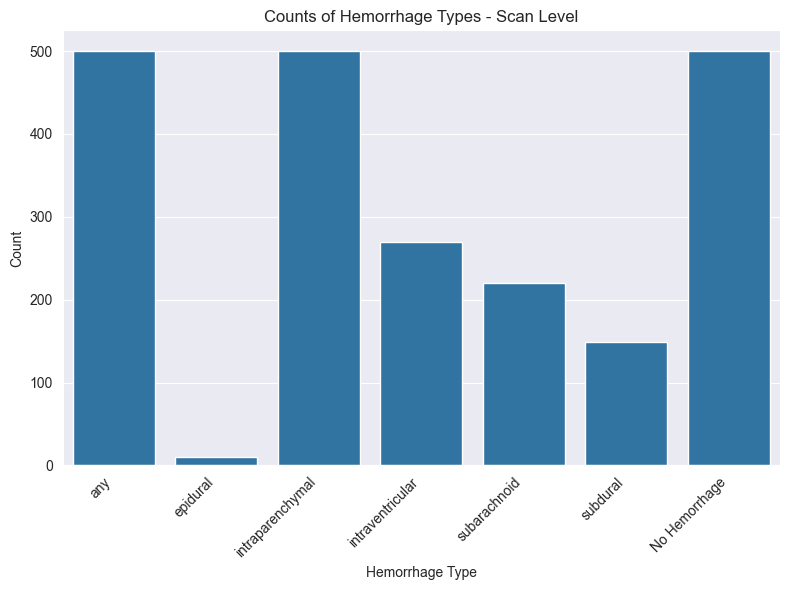

In [16]:
# Count occurrences of each hemorrhage type in the extracted patients DataFrame
hemorrhage_counts_extracted = extracted_patients[['any', 'epidural', 'intraparenchymal',
                                                  'intraventricular', 'subarachnoid',
                                                  'subdural']].sum()

# Count occurrences of patients not having any specified hemorrhage types (all labels are 0)
extracted_patients['no_hemorrhage'] = extracted_patients.apply(
    lambda row: 1 if row[['any', 'epidural', 'intraparenchymal',
                          'intraventricular', 'subarachnoid',
                          'subdural']].sum() == 0 else 0, axis=1)

# Sum the counts of patients with no hemorrhage
no_hemorrhage_count = extracted_patients['no_hemorrhage'].sum()

# Convert counts to a DataFrame for plotting purposes
hemorrhage_counts_extracted = hemorrhage_counts_extracted.reset_index()
hemorrhage_counts_extracted.columns = ['hemorrhage_type', 'count']

# Create a DataFrame for the "No Hemorrhage" category
no_hemorrhage_df = pd.DataFrame({'hemorrhage_type': ['No Hemorrhage'], 'count': [no_hemorrhage_count]})

# Combine "No Hemorrhage" counts with existing hemorrhage counts DataFrame
combined_hemorrhage_counts = pd.concat([hemorrhage_counts_extracted, no_hemorrhage_df], ignore_index=True)

# Create a bar chart to visualize counts of hemorrhage types in extracted patients data
plt.figure(figsize=(8, 6))
sns.barplot(x='hemorrhage_type', y='count', data=combined_hemorrhage_counts)
plt.title('Counts of Hemorrhage Types - Scan Level')
plt.xlabel('Hemorrhage Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()